In [10]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from mord import LogisticIT
import matplotlib.pylab as plt
import seaborn as sns
from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score



In [11]:
bank_df = pd.read_csv("D:/dmba/UniversalBank.csv")
bank_df.drop(columns=['ID', 'ZIP Code'], inplace=True)
bank_df.columns = [c.replace(' ', '_') for c in bank_df.columns]

bank_df['Education'] = bank_df['Education'].astype('category')
new_categories = {1:'Undergrad', 2:'Graduate', 3:'Advanced/Professional'}
bank_df.Education.cat.rename_categories(new_categories)
bank_df = pd.get_dummies(bank_df, prefix_sep='_', drop_first=True)
bank_df.columns

Index(['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Mortgage',
       'Personal_Loan', 'Securities_Account', 'CD_Account', 'Online',
       'CreditCard', 'Education_2', 'Education_3'],
      dtype='object')

In [12]:
y = bank_df['Personal_Loan']
X = bank_df.drop(columns=['Personal_Loan'])

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

logit_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

print('intercept ', logit_reg.intercept_)
print(pd.DataFrame({'coeff':logit_reg.coef_[0]}, index=X.columns).transpose())

print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

intercept  [-12.6316267]
            Age  Experience    Income    Family     CCAvg  Mortgage  \
coeff -0.032052    0.033667  0.058825  0.614463  0.240512  0.001012   

       Securities_Account  CD_Account    Online  CreditCard  Education_2  \
coeff           -1.030099    3.653239 -0.677388   -0.957917     4.190596   

       Education_3  
coeff     4.340342  
AIC -709.1524769205962


In [13]:
logit_reg_pred = logit_reg.predict(valid_X)
logit_reg_proba = logit_reg.predict_proba(valid_X)
logit_result = pd.DataFrame({'actual':valid_y, 'p(0)':[p[0] for p in logit_reg_proba], 'p(1)':[p[1] for p in logit_reg_proba], 'predicted':logit_reg_pred})

interestingCases = [2764, 932, 2721, 702]
print(logit_result.loc[interestingCases])

      actual      p(0)      p(1)  predicted
2764       0  0.976223  0.023777          0
932        0  0.334948  0.665052          1
2721       1  0.031655  0.968345          1
702        1  0.985699  0.014301          0


In [14]:
classificationSummary(train_y, logit_reg.predict(train_X))
classificationSummary(valid_y, logit_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.9603)

       Prediction
Actual    0    1
     0 2684   29
     1   90  197
Confusion Matrix (Accuracy 0.9595)

       Prediction
Actual    0    1
     0 1791   16
     1   65  128


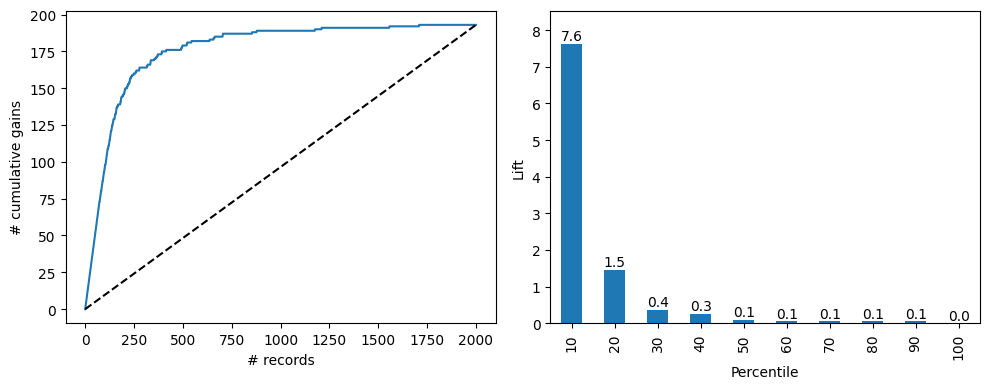

In [15]:
df = logit_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(df.actual, ax=axes[0])
liftChart(df.actual, title=False, ax=axes[1])

plt.tight_layout()
plt.show()

In [16]:
df.actual

3373    1
2217    1
787     1
47      1
3006    1
       ..
1100    0
4922    0
1720    0
3125    0
551     0
Name: actual, Length: 2000, dtype: int64

In [17]:
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

data = pd.read_csv("D:/dmba/accidentsFull.csv")
outcome = 'MAX_SEV_IR'
predictors = ['ALCHL_I', 'WEATHER_R']

y = data[outcome]
X = data[predictors]
train_X, train_y = X, y

print('Nominal logistic regression')
logit = LogisticRegression(penalty='l2', solver='lbfgs', multi_class='multinomial')
logit.fit(X, y)
print('intercept', logit.intercept_)
print('coefficients', logit.coef_)
print()

Nominal logistic regression
intercept [-0.17095104  0.82307837 -0.65212733]
coefficients [[ 0.52167271  0.40278601]
 [ 0.15490957  0.15933088]
 [-0.67658228 -0.56211689]]



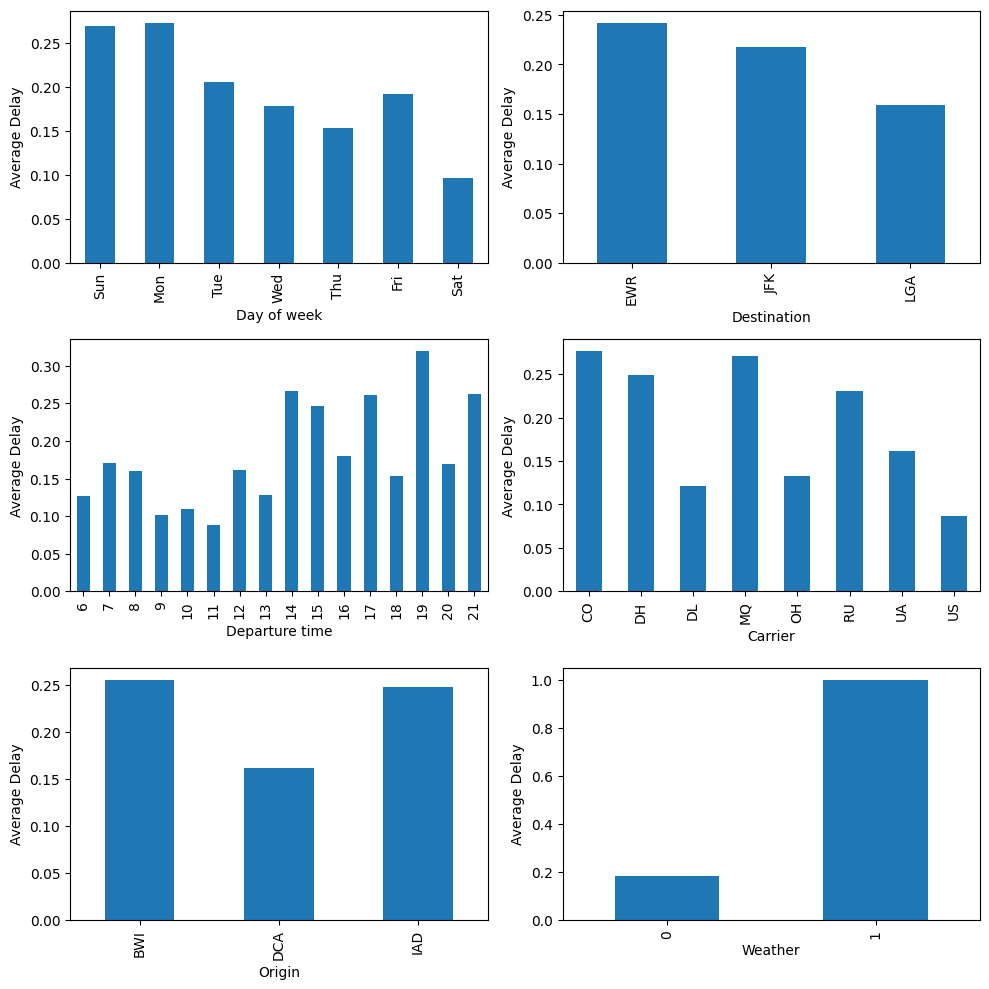

In [21]:
delays_df = pd.read_csv("D:/dmba/FlightDelays.csv")
delays_df['isDelayed'] = [1 if status == 'delayed' else 0 for status in delays_df['Flight Status']]

def createGraph(group, xlabel, axis):
    groupAverage = delays_df.groupby([group])['isDelayed'].mean()
    if group == 'DAY_WEEK':
        groupAverage = groupAverage.reindex(index=np.roll(groupAverage.index, 1))
        groupAverage.index = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
    ax = groupAverage.plot.bar(color='C0', ax=axis)
    ax.set_ylabel('Average Delay')
    ax.set_xlabel(xlabel)
    return ax

def graphDepartureTime(xlabel, axis):
    temp_df = pd.DataFrame({'CRS_DEP_TIME':delays_df['CRS_DEP_TIME']//100,
                            'isDelayed': delays_df['isDelayed']})
    groupAverage = temp_df.groupby(['CRS_DEP_TIME'])['isDelayed'].mean()
    ax = groupAverage.plot.bar(color='C0', ax = axis)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Average Delay')

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

createGraph('DAY_WEEK', 'Day of week', axis=axes[0][0])
createGraph('DEST', 'Destination', axis=axes[0][1])
graphDepartureTime('Departure time', axis=axes[1][0])
createGraph('CARRIER', 'Carrier', axis=axes[1][1])
createGraph('ORIGIN', 'Origin', axis=axes[2][0])
createGraph('Weather', 'Weather', axis=axes[2][1])
plt.tight_layout()

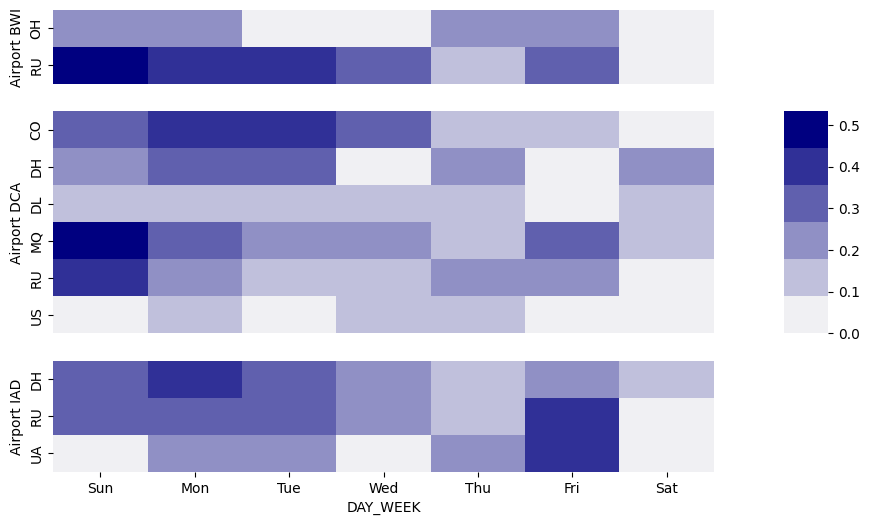

In [24]:
agg = delays_df.groupby(['ORIGIN', 'DAY_WEEK', 'CARRIER']).isDelayed.mean()
agg = agg.reset_index()

height_ratios = []
for i, origin in enumerate(sorted(delays_df.ORIGIN.unique())):
    height_ratios.append(len(agg[agg.ORIGIN == origin].CARRIER.unique()))
gridspec_kw = {'height_ratios':height_ratios, 'width_ratios':[15, 1]}
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,6), gridspec_kw = gridspec_kw) 

axes[0,1].axis('off')
axes[2,1].axis('off')

maxIsDelay = agg.isDelayed.max()
for i, origin in enumerate(sorted(delays_df.ORIGIN.unique())):
    data = pd.pivot_table(agg[agg.ORIGIN == origin], values='isDelayed', index=['CARRIER'], columns=['DAY_WEEK'])
    data = data[[7,1,2,3,4,5,6]]
    ax = sns.heatmap(data, ax=axes[i][0], vmin=0, vmax=maxIsDelay,
                     cbar_ax=axes[1][1], cmap=sns.light_palette('navy'))
    ax.set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
    if i != 2:
        ax.get_xaxis().set_visible(False)
    ax.set_ylabel('Airport ' + origin)
plt.show()

In [ ]:
delays_df = pd.read_csv("D:/dmba/FlightDelays.csv")
